In [64]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


## Data Preprocessing

In [145]:
# Hyperparameters

# y column normalize scaler
normalizer_constant = 2

# time series step size
time_step = 50

# NN parameters
learning_rate = 0.3
num_epoch = 500
NN_layer_dimension = [100,100]
train_size = 568 # 80% of the data

In [102]:
SNP = pd.read_csv('./SP500.csv')

# get columns 2-6 (X)
# SNP_attribute = SNP.iloc[:,1:6]
# get last column (y)
SNP_price = SNP.iloc[:,-1:]

# normalize the data using MinMax scaller
# scaler = MinMaxScaler()
# scaler.fit(SNP_attribute)
# SNP_attribute = scaler.transform(SNP_attribute)

Price_scaler = MinMaxScaler(feature_range=(0,1))
Price_scaler.fit(SNP_price)
SNP_price = Price_scaler.transform(SNP_price)

# scale data to [0,1]
# SNP_price = (SNP_price-SNP_price.min())/((SNP_price.max()*normalizer_constant)-SNP_price.min())

train_data = SNP_price[0:train_size, :]

def create_train_data(data):
    x = []
    y = []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i,0])
        y.append(data[i,0])
    return x, y

X_train, y_train = create_train_data(train_data)


[array([3.46193439e-03, 3.08150204e-03, 3.29185875e-03, 3.10611825e-03,
        2.28483194e-03, 8.70518731e-04, 8.27999821e-05, 5.05751242e-04,
        6.87016068e-04, 0.00000000e+00, 3.64767489e-04, 1.44340509e-03,
        1.61124289e-03, 2.42134002e-03, 1.92677796e-03, 2.54218323e-03,
        3.24038849e-03, 3.40151278e-03, 2.99198854e-03, 3.03898313e-03,
        3.84236674e-03, 3.74390189e-03, 4.10419371e-03, 4.06615047e-03,
        4.46224768e-03, 4.80687464e-03, 5.03065837e-03, 5.31486372e-03,
        5.52298259e-03, 5.50955557e-03, 5.99292843e-03, 6.15629056e-03,
        5.97278790e-03, 6.39797700e-03, 6.64413910e-03, 6.27937162e-03,
        6.43154456e-03, 7.18122007e-03, 7.10737144e-03, 6.89925256e-03,
        7.55046323e-03, 7.43633353e-03, 6.48749049e-03, 6.69784720e-03,
        7.08946874e-03, 7.70039834e-03, 8.22181444e-03, 8.05845231e-03,
        8.21062525e-03, 8.20614958e-03]),
 array([3.08150204e-03, 3.29185875e-03, 3.10611825e-03, 2.28483194e-03,
        8.70518731e-04

In [103]:
# Reshaping 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [148]:
# NN 
def create_model(units=[12,3], learning_rate=0.3):
    model = tf.keras.models.Sequential()
    # model.add(tf.keras.layers.Input(shape=(5,)))
    # model.add(tf.keras.layers.Dense(units[0], activation=tf.nn.relu))
    # model.add(Dropout(0.2))
    # model.add(tf.keras.layers.Dense(units[1], activation=tf.nn.relu))
    # model.add(Dropout(0.2))
    # model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

    # LSTM RNN model
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=False))
    # model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))


    # opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer='adam',loss='mean_squared_error')

    return model

model = create_model(units=NN_layer_dimension, learning_rate=learning_rate)




In [149]:
# Train
model.fit(X_train, y_train, epochs=200, batch_size=25, verbose=1)

Epoch 1/200
21/21 [==============================] - 3s 23ms/step - loss: 0.0029
Epoch 2/200
21/21 [==============================] - 0s 23ms/step - loss: 5.9429e-04
Epoch 3/200
21/21 [==============================] - 0s 22ms/step - loss: 4.0933e-04
Epoch 4/200
21/21 [==============================] - 0s 22ms/step - loss: 3.1384e-04
Epoch 5/200
21/21 [==============================] - 0s 22ms/step - loss: 3.1067e-04
Epoch 6/200
21/21 [==============================] - 0s 22ms/step - loss: 2.5518e-04
Epoch 7/200
21/21 [==============================] - 0s 22ms/step - loss: 2.7785e-04
Epoch 8/200
21/21 [==============================] - 0s 22ms/step - loss: 2.0923e-04
Epoch 9/200
21/21 [==============================] - 0s 23ms/step - loss: 1.7587e-04
Epoch 10/200
21/21 [==============================] - 0s 22ms/step - loss: 1.9406e-04
Epoch 11/200
21/21 [==============================] - 0s 22ms/step - loss: 1.6658e-04
Epoch 12/200
21/21 [==============================] - 0s 22ms/step 

In [150]:
test_data = SNP_price[train_size - time_step:, :]
X_test = []
y_test = SNP_price[train_size:, :]
for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i,0])


X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
len(test_data)

199

In [151]:
predicted_price = model.predict(X_test)
predicted_price = Price_scaler.inverse_transform(predicted_price)
predicted_price.shape

(149, 1)

/var/folders/86/p93c5vrd78lblk3lsz04s3r00000gn/T/ipykernel_3753/78252439.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_price


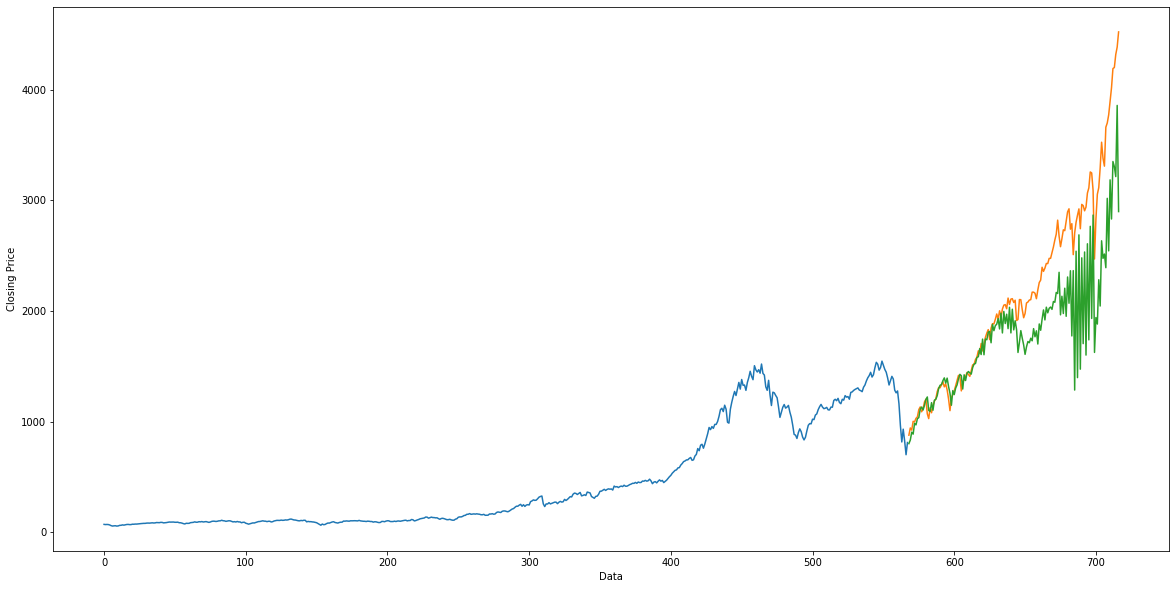

In [152]:
plt.figure(figsize=(20,10))
training = SNP[:train_size]
valid = SNP[train_size:]
valid.shape
valid['pred'] = predicted_price


#plot
plt.xlabel('Data')
plt.ylabel('Closing Price')
plt.plot(training["Closing Price"])
plt.plot(valid[['Closing Price', 'pred']])

